In [ ]:
import MDAnalysis as mda
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.ticker as ticker
import matplotlib as mpl
import numpy as np

# Initialize Universe with Gromacs files
u = mda.Universe('npt_modified.gro', 'centered_nojump_md.xtc')

# Select alpha and beta
alpha = u.select_atoms('bynum 1:4368')
beta = u.select_atoms('bynum 4506:8802')

# Select the MTBD helices
mtbd_selections = {
    'MTBD-H1': u.select_atoms('resid 3301:3309'),
    'MTBD-H2': u.select_atoms('resid 3315:3329'),
    'MTBD-H3': u.select_atoms('resid 3335:3341'),
    'MTBD-H4': u.select_atoms('resid 3347:3352'),
    'MTBD-H5': u.select_atoms('resid 3361:3370'),
    'MTBD-H7': u.select_atoms('resid 3379:3385'),
}

In [10]:
# Initialize an empty DataFrame
df = pd.DataFrame()

# Initialize an empty array for time
time = None

# Iterate over each MTBD selection
for selection_name, selection in mtbd_selections.items():
    dcom_values_alpha = []
    dcom_values_beta = []
    # Calculate the DCOM for each time step in the trajectory
    for ts in u.trajectory:
        dcom_alpha = np.linalg.norm(alpha.center_of_mass() - selection.center_of_mass())
        dcom_beta = np.linalg.norm(beta.center_of_mass() - selection.center_of_mass())
        dcom_values_alpha.append(dcom_alpha)
        dcom_values_beta.append(dcom_beta)
    # Compute time in nanoseconds assuming trajectory timestep is in femtoseconds
    time = np.arange(len(dcom_values_alpha)) * u.trajectory.dt / 1000  # time in ns
    # Store the DCOM values in the DataFrame
    df[selection_name + ' Alpha DCOM (Å)'] = dcom_values_alpha
    df[selection_name + ' Beta DCOM (Å)'] = dcom_values_beta

# If you want to add time to the DataFrame as well, you can do so after the loop:
    df['Time (ns)'] = time

In [13]:
import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['font.family'] = 'Times New Roman'

def plot_graphs(df, time, mtbd_selections, window_size=100):
    print('zoomed in graphs')

    # Append time to df
    df['Time (ns)'] = time

    # Smooth and plot DCOM for each selection
    for selection_name in mtbd_selections.keys():
        df['Smoothed ' + selection_name + ' Alpha DCOM (Å)'] = df[selection_name + ' Alpha DCOM (Å)'].rolling(window=window_size).mean()
        df['Smoothed ' + selection_name + ' Beta DCOM (Å)'] = df[selection_name + ' Beta DCOM (Å)'].rolling(window=window_size).mean()

        # Get maximum y value
        y_max = max(df['Smoothed ' + selection_name + ' Alpha DCOM (Å)'].max(), df['Smoothed ' + selection_name + ' Beta DCOM (Å)'].max()) * 1.15

        # Create the figure and axes
        fig, ax = plt.subplots()
        ax.set_xlabel('Time (ns)')
        ax.set_ylabel('DCOM (Å)')

        # Set figure size
        fig.set_size_inches(10, 8)

        # Set major and minor ticks
        ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))

        # Turn off the right and top spines
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)


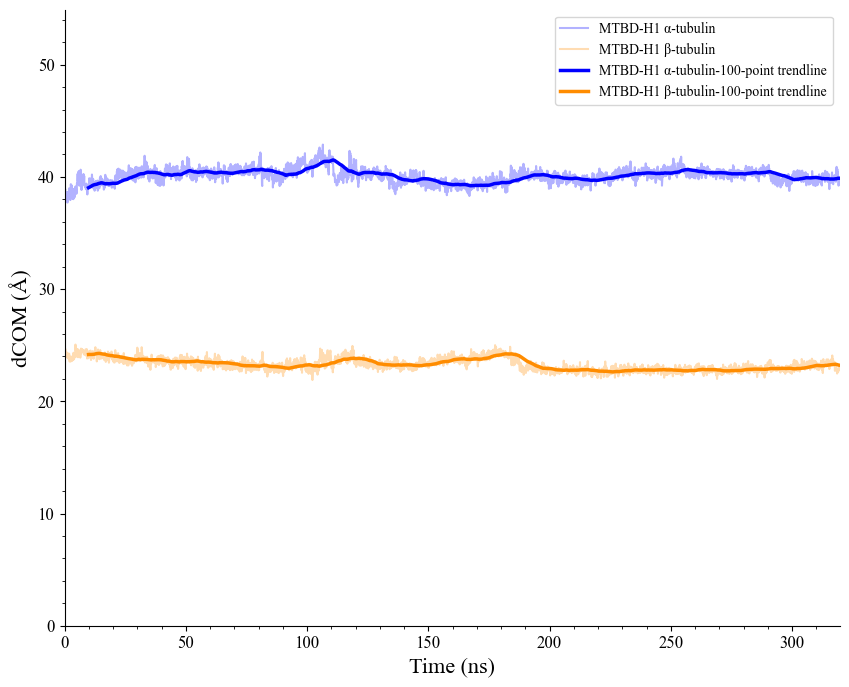

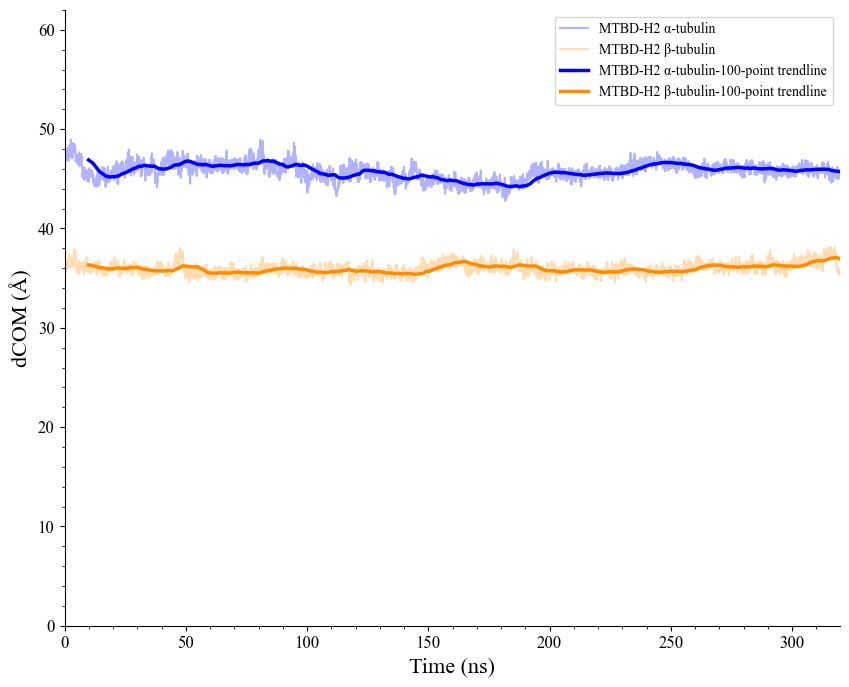

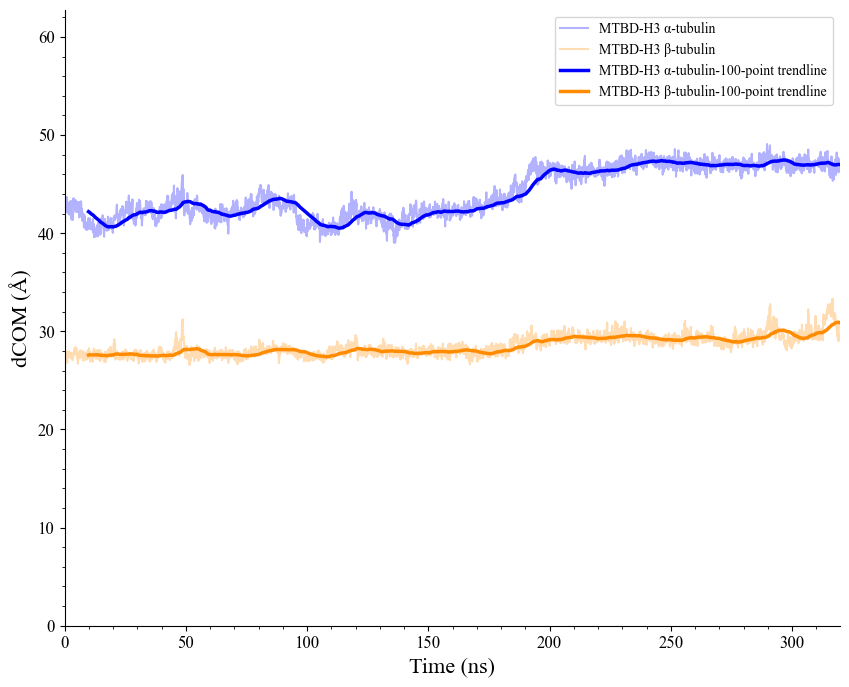

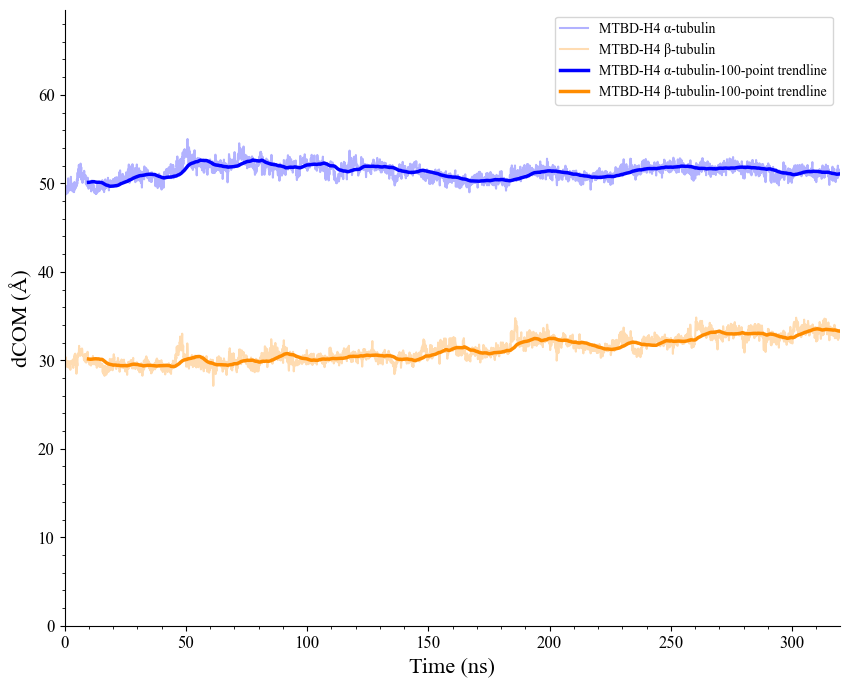

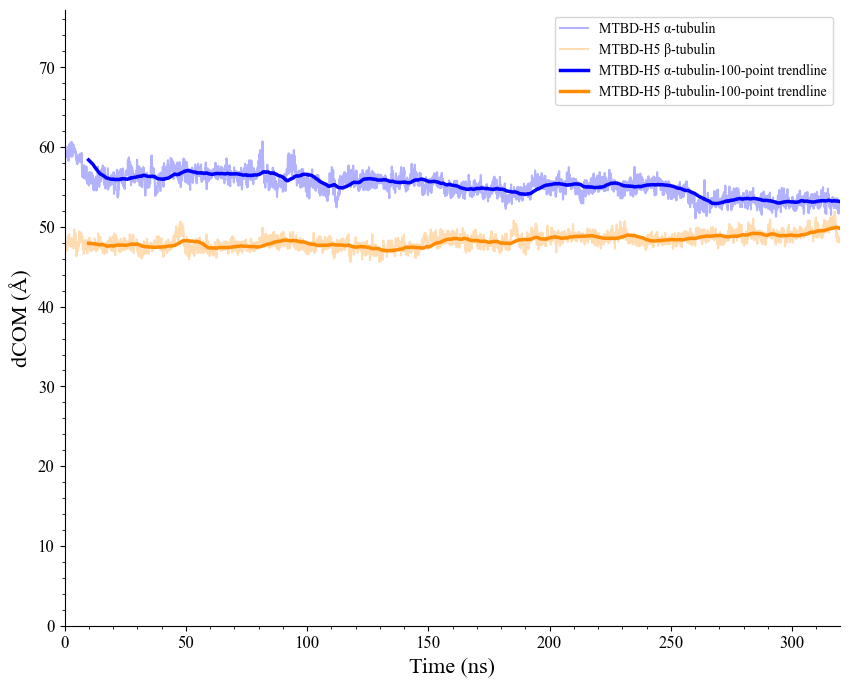

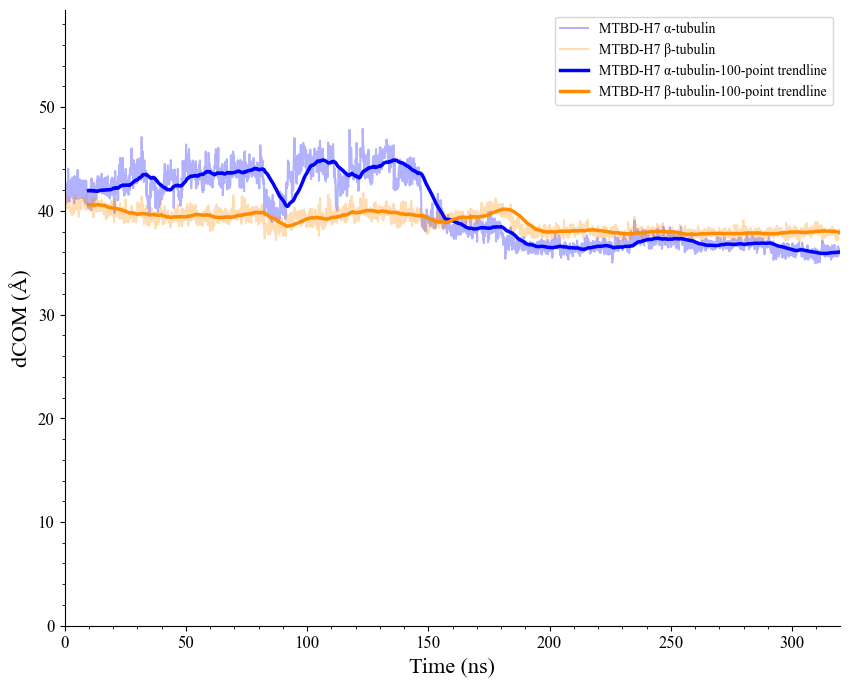

In [33]:
# Define a function for the common plot setup
def setup_plot(xlabel, ylabel):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 8)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(2))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)  # Set tick label size
    return fig, ax

# Set the font to Times New Roman
mpl.rcParams['font.family'] = 'Times New Roman'

# Define a window size for smoothing
window_size = 100

# Add the time to df
df['Time (ns)'] = time

# Smooth and plot DCOM for each selection
for selection_name in mtbd_selections.keys():
    df['Smoothed ' + selection_name + ' Alpha DCOM (Å)'] = df[selection_name + ' Alpha DCOM (Å)'].rolling(window=window_size).mean()
    df['Smoothed ' + selection_name + ' Beta DCOM (Å)'] = df[selection_name + ' Beta DCOM (Å)'].rolling(window=window_size).mean()

    # Get maximum y value
    y_max = max(df['Smoothed ' + selection_name + ' Alpha DCOM (Å)'].max(), df['Smoothed ' + selection_name + ' Beta DCOM (Å)'].max()) * 1.15

    # Setup the plot
    fig, ax = setup_plot('Time (ns)', 'dCOM (Å)')
    
    # Plot the DCOM values
    sns.lineplot(x='Time (ns)', y=selection_name + ' Alpha DCOM (Å)', data=df, ax=ax, color='blue', alpha=0.3, label=selection_name +' α-tubulin')
    sns.lineplot(x='Time (ns)', y=selection_name + ' Beta DCOM (Å)', data=df, ax=ax, color='darkorange', alpha=0.3, label=selection_name +' β-tubulin')

    # Plot the smoothed DCOM values
    sns.lineplot(x='Time (ns)', y='Smoothed ' + selection_name + ' Alpha DCOM (Å)', data=df, ax=ax, color='blue', linewidth=2.5, label=selection_name +' α-tubulin-100-point trendline')
    sns.lineplot(x='Time (ns)', y='Smoothed ' + selection_name + ' Beta DCOM (Å)', data=df, ax=ax, color='darkorange', linewidth=2.5, label=selection_name +' β-tubulin-100-point trendline')

    # Set y-axis to start from 0 and go up to y_max
    ax.set_ylim(0, (y_max)*1.15)

    # Set x-axis to start from 0
    ax.set_xlim(0, max(df['Time (ns)']))

    # Show the legend
    legend = plt.legend(loc='upper right', bbox_to_anchor=(1,1), ncol=1)
    plt.setp(legend.get_texts(), color='black')
    
    # Save and show the plot
    plt.savefig(f"Final Graphs/{selection_name}_b_a.png", dpi=300)
    plt.show()


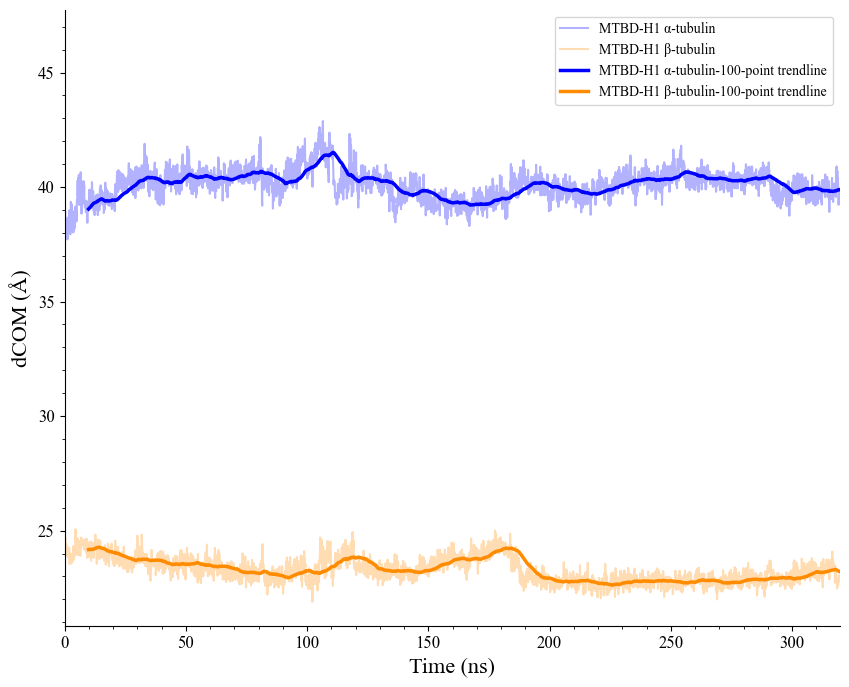

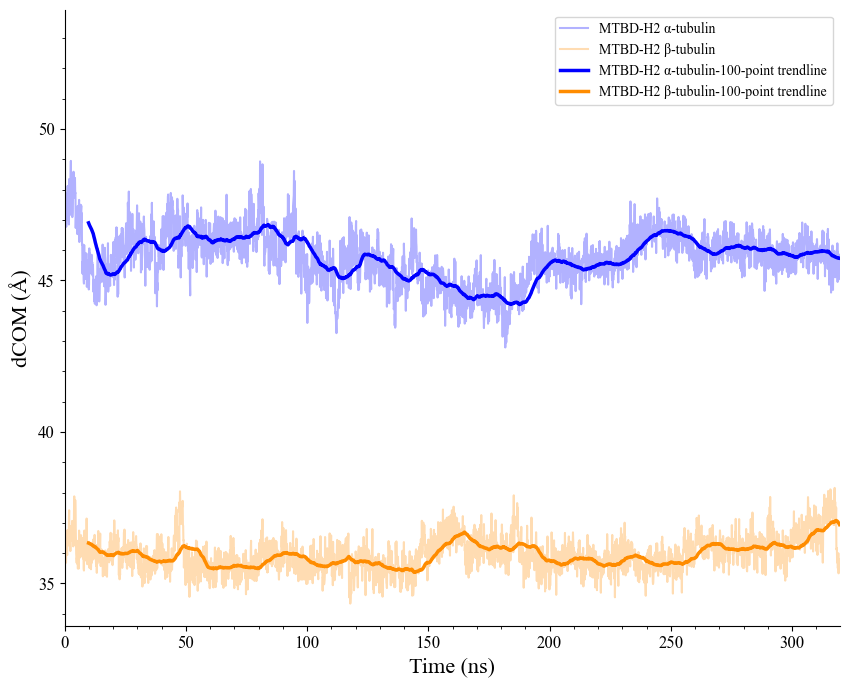

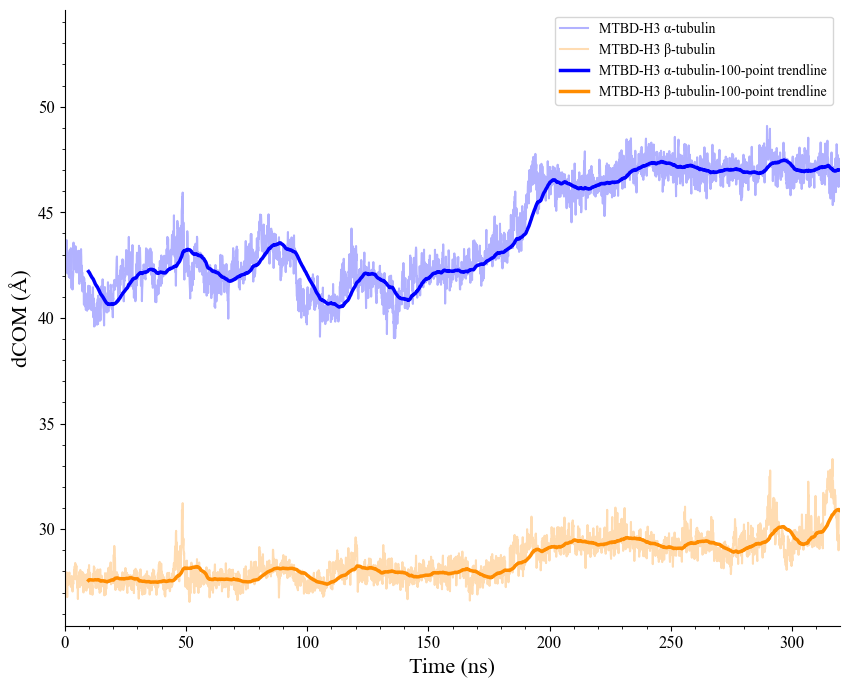

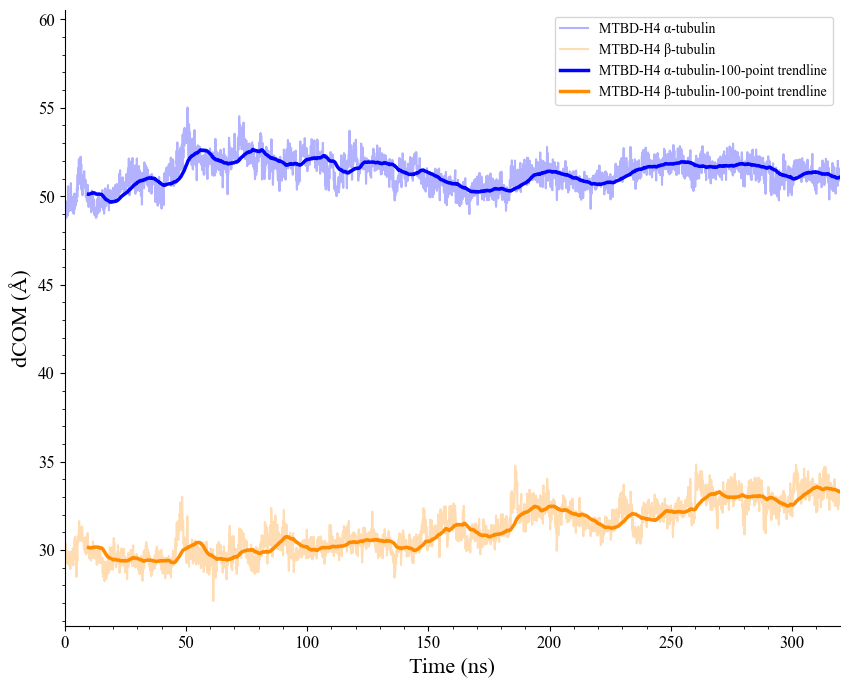

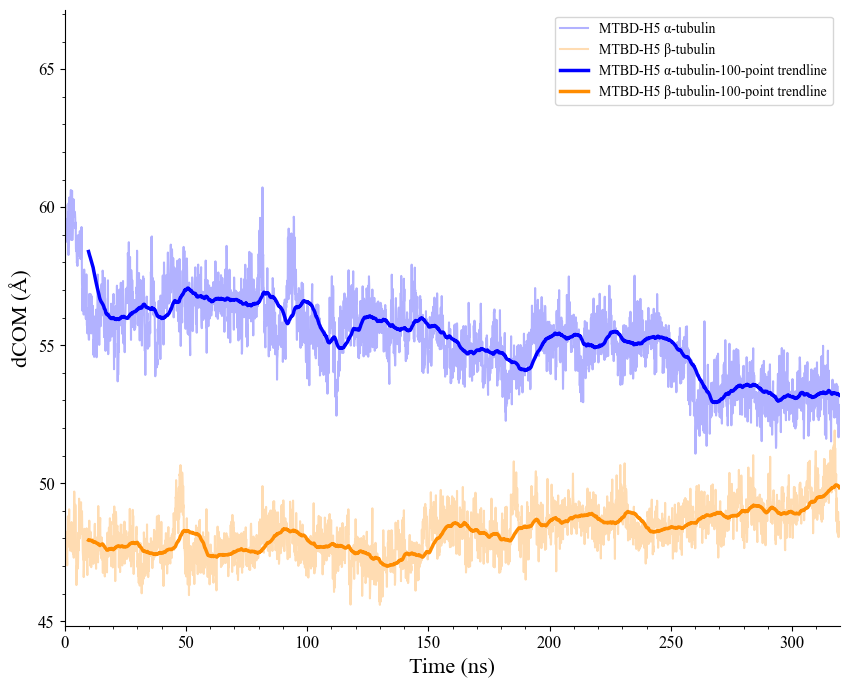

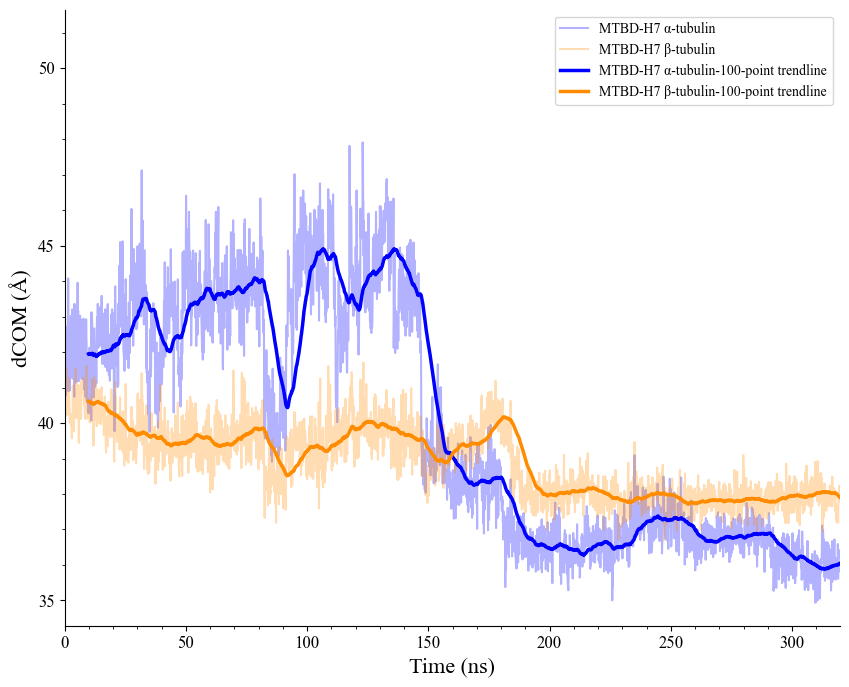

In [30]:
# Define a function for the common plot setup
def setup_plot(xlabel, ylabel):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 8)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)  # Set tick label size
    return fig, ax
# Set the font to Times New Roman
mpl.rcParams['font.family'] = 'Times New Roman'

# Define a window size for smoothing
window_size = 100

# Add the time to df
df['Time (ns)'] = time

# Smooth and plot DCOM for each selection
for selection_name in mtbd_selections.keys():
    df['Smoothed ' + selection_name + ' Alpha DCOM (Å)'] = df[selection_name + ' Alpha DCOM (Å)'].rolling(window=window_size).mean()
    df['Smoothed ' + selection_name + ' Beta DCOM (Å)'] = df[selection_name + ' Beta DCOM (Å)'].rolling(window=window_size).mean()

    # Get maximum y value
    y_max = max(df['Smoothed ' + selection_name + ' Alpha DCOM (Å)'].max(), df['Smoothed ' + selection_name + ' Beta DCOM (Å)'].max()) * 1.15

    # Setup the plot
    fig, ax = setup_plot('Time (ns)', 'dCOM (Å)')
    
    # Plot the DCOM values
    # Plot the DCOM values
    sns.lineplot(x='Time (ns)', y=selection_name + ' Alpha DCOM (Å)', data=df, ax=ax, color='blue', alpha=0.3, label=selection_name +' α-tubulin')
    sns.lineplot(x='Time (ns)', y=selection_name + ' Beta DCOM (Å)', data=df, ax=ax, color='darkorange', alpha=0.3, label=selection_name +' β-tubulin')

    # Plot the smoothed DCOM values
    sns.lineplot(x='Time (ns)', y='Smoothed ' + selection_name + ' Alpha DCOM (Å)', data=df, ax=ax, color='blue', linewidth=2.5, label=selection_name +' α-tubulin-100-point trendline')
    sns.lineplot(x='Time (ns)', y='Smoothed ' + selection_name + ' Beta DCOM (Å)', data=df, ax=ax, color='darkorange', linewidth=2.5, label=selection_name +' β-tubulin-100-point trendline')

    # Set y-axis to start from 0 and go up to y_max
    ax.set_ylim(None, y_max)

    # Set x-axis to start from 0
    ax.set_xlim(0, max(df['Time (ns)']))

    # Show the legend
    plt.legend(loc='upper right')

    # Save and show the plot
    plt.savefig(f"Final Graphs/{selection_name}_CTT_abs.png", dpi=300)
    plt.show()
